<a href="https://colab.research.google.com/github/LukeFic/AE-353/blob/main/370Project1Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

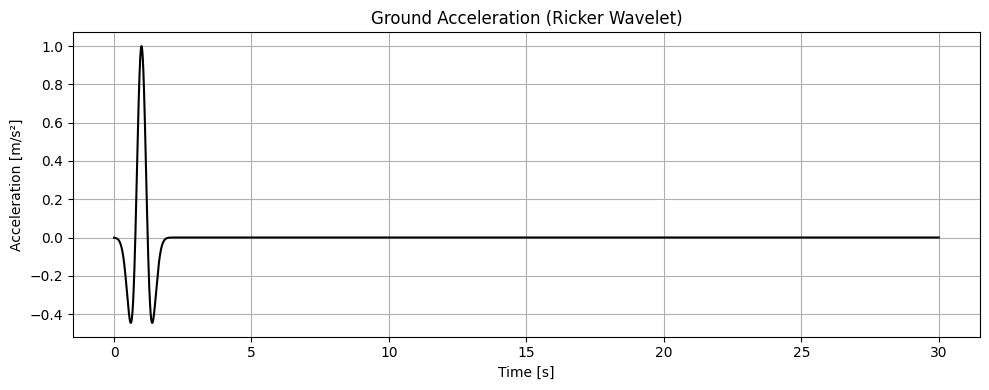

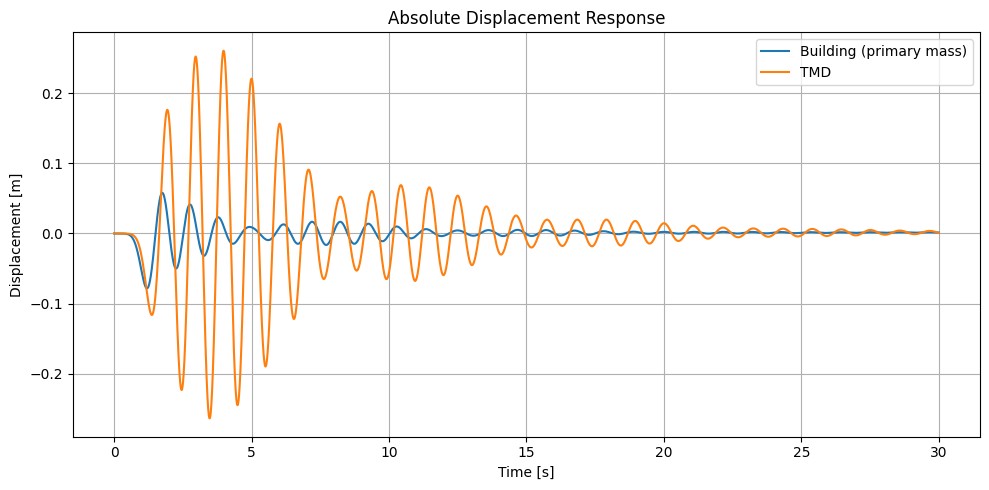

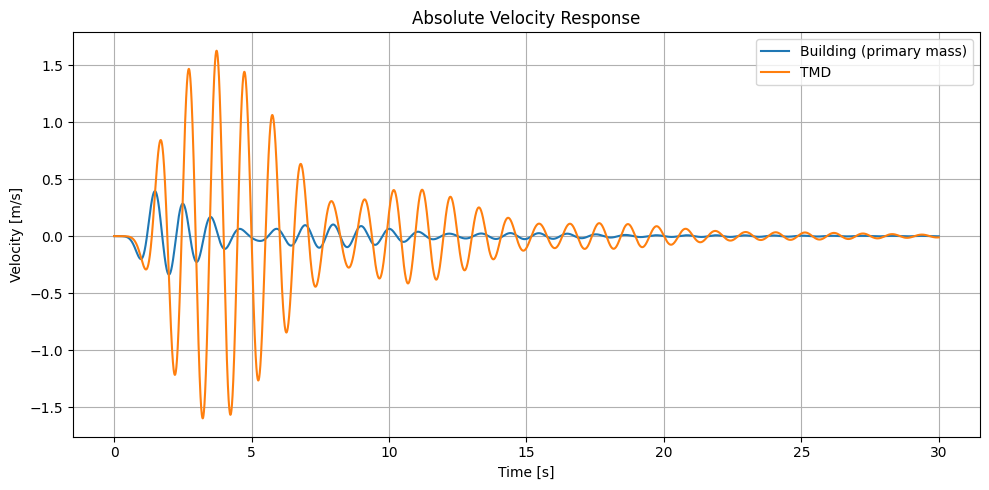

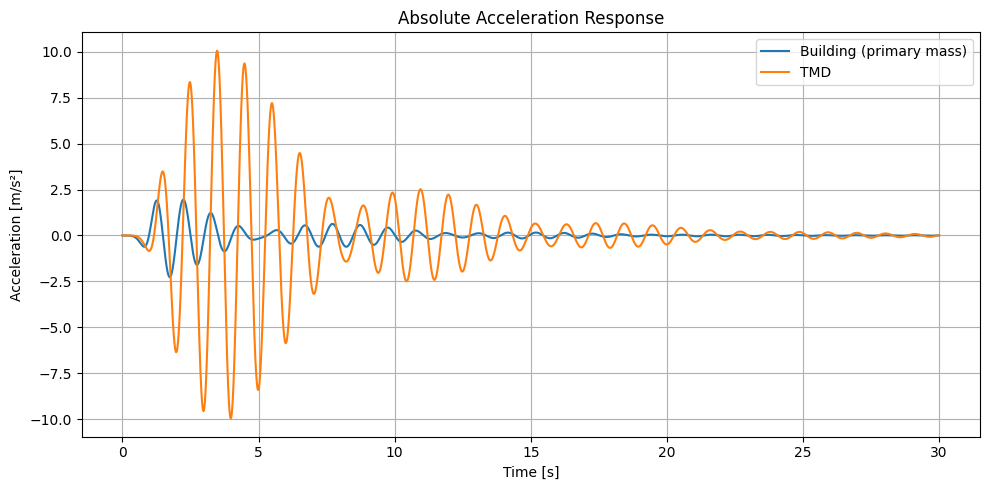

Peak Displacement (Building): 0.0784 m
Peak Displacement (TMD):      0.2640 m
Peak Velocity (Building):     0.3942 m/s
Peak Velocity (TMD):          1.6274 m/s
Peak Accel (Building):        2.2686 m/s²
Peak Accel (TMD):             10.0607 m/s²


In [60]:
import numpy as np
import matplotlib.pyplot as plt
#variables
m1 = 1000.0     # Mass Building [kg]
f1 = 1.0        # Natural frequency of building [Hz]
zeta1 = 0.02    # Damping ratio of building
TMD_ratio = .02 # Ratio of TMD mass to building mass

m2 = m1*TMD_ratio # Mass TMD [kg]
f2 = 1.0        # Natural frequency of TMD (tuned to f1)
zeta2 = 0.05    # Damping ratio of TMD

f0 = 1.0        # Frequency of Ricker//Earthquake [Hz]
A = 1.0         # Amplitude [m/s^2]
t_center = 1.0  # Peak Time[s]

dt = 0.002      # Time step [s]
T = 30.0        # Total simulation time [s]

# 2. Equation of Motions
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

k1 = m1 * omega1**2
k2 = m2 * omega2**2
c1 = 2 * zeta1 * m1 * omega1
c2 = 2 * zeta2 * m2 * omega2

M = np.array([[m1, 0],
              [0,  m2]])
C = np.array([[c1 + c2, -c2],
              [-c2,      c2]])
K = np.array([[k1 + k2, -k2],
              [-k2,      k2]])


# 3. Earthquake (Ricker wavelet) #commonly used model for earthquake shock
def ricker(t, f0):
    a = np.pi * f0 * t
    return (1 - 2 * a**2) * np.exp(-a**2)

t = np.arange(0, T + dt, dt)
ag = A * ricker(t - t_center, f0)  # Ground acceleration [m/s^2]


# 4. INITIAL CONDITIONS
r = np.zeros((len(t), 2))       # Relative displacements
r_dot = np.zeros((len(t), 2))   # Relative velocities
r_ddot = np.zeros((len(t), 2))  # Relative accelerations

# Initial acceleration from equilibrium: M r_ddot = -C r_dot - K r - M * 1 * ag
F0 = -M.dot(np.array([1, 1])) * ag[0]
r_ddot[0] = np.linalg.solve(M, F0 - C @ r_dot[0] - K @ r[0])

#5.
# TRAPEZOIDAL RULE FORMULATION
# (M + Δt/2*C + Δt^2/4*K) r_ddot_{k+1} = F_{k+1} - C( r_dot_k + Δt/2*r_ddot_k )
#                                    - K( r_k + Δt/2*r_dot_k + Δt^2/4*r_ddot_k )
K_eff = M + 0.5 * dt * C + 0.25 * dt**2 * K
K_eff_inv = np.linalg.inv(K_eff)

#generate answers for Trapezoidal
def trapezoidal_rule(M,c,k, F, dt, r_0, v_0):
  for k in range(len(t) - 1):
    F_next = -M.dot(np.array([1, 1])) * ag[k + 1]

    rhs = (F_next
           - C.dot(r_dot[k] + 0.5 * dt * r_ddot[k])
           - K.dot(r[k] + 0.5 * dt * r_dot[k] + 0.25 * dt**2 * r_ddot[k]))

    r_ddot[k + 1] = K_eff_inv.dot(rhs)
    r_dot[k + 1] = r_dot[k] + 0.5 * dt * (r_ddot[k] + r_ddot[k + 1])
    r[k + 1] = r[k] + dt * r_dot[k] + 0.25 * dt**2 * (r_ddot[k] + r_ddot[k + 1])
  return r, r_dot, r_ddot


# 7. ABSOLUTE MOTION (structure motion + ground)
vg = np.cumsum(ag) * dt
xg = np.cumsum(vg) * dt
trapezoidal_rule(M,C,K, F0, dt, 0, 0)
u = r + xg.reshape(-1, 1) * np.array([1, 1])
u_dot = r_dot + vg.reshape(-1, 1) * np.array([1, 1])
u_ddot = r_ddot + ag.reshape(-1, 1) * np.array([1, 1])


###LETS ADD A PLOT FOR ABSOLUTE ERROR TO SHOW WE ARE SECOND DEGREE ACCURATE, TO BACK UP OUR CLAIMS IN THE REPORT
##ALSO CHANGE THE CODE TO LOOK LESS CHAT GPT, RECODE THE TRAPEZOIDAL RULE TO HAVE MORE STEPS

# 8. PLOTS
plt.figure(figsize=(10, 4))
plt.plot(t, ag, color='black')
plt.title('Ground Acceleration (Ricker Wavelet)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u[:, 0], label='Building (primary mass)')
plt.plot(t, u[:, 1], label='TMD')
plt.title('Absolute Displacement Response')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_dot[:, 0], label='Building (primary mass)')
plt.plot(t, u_dot[:, 1], label='TMD')
plt.title('Absolute Velocity Response')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_ddot[:, 0], label='Building (primary mass)')
plt.plot(t, u_ddot[:, 1], label='TMD')
plt.title('Absolute Acceleration Response')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Simulate building without TMD here



# 9. SUMMARY OUTPUT
print(f"Peak Displacement (Building): {np.max(np.abs(u[:,0])):.4f} m")
print(f"Peak Displacement (TMD):      {np.max(np.abs(u[:,1])):.4f} m")
print(f"Peak Velocity (Building):     {np.max(np.abs(u_dot[:,0])):.4f} m/s")
print(f"Peak Velocity (TMD):          {np.max(np.abs(u_dot[:,1])):.4f} m/s")
print(f"Peak Accel (Building):        {np.max(np.abs(u_ddot[:,0])):.4f} m/s²")
print(f"Peak Accel (TMD):             {np.max(np.abs(u_ddot[:,1])):.4f} m/s²")

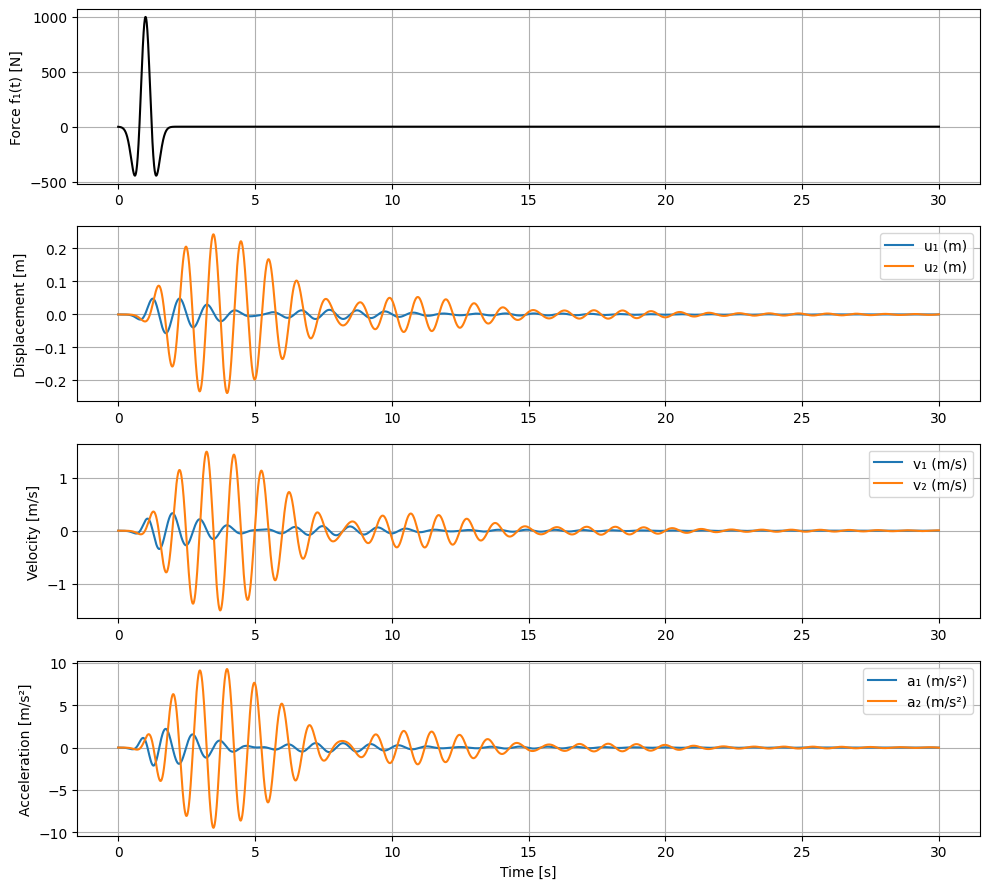

In [61]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def f1(t):
    return m1*ricker(t - 1.0, f0)   # centered at t = 1

# --- State equations ---
def xdot(t, x):
    x1, x2, x3, x4 = x  # [u1, u1dot, u2, u2dot]
    dx1 = x2
    dx2 = (1.0/m1) * ( f1(t) - (c1+c2)*x2 + c2*x4 - (k1+k2)*x1 + k2*x3 )
    dx3 = x4
    dx4 = (1.0/m2) * ( c2*(x2 - x4) + k2*(x1 - x3) )
    return [dx1, dx2, dx3, dx4]

# --- Initial conditions and time span ---
x0 = [0.0, 0.0, 0.0, 0.0]
t_span = (0.0, 30.0)
t_eval = np.linspace(t_span[0], t_span[1], 4001)

# --- Integrate ---
sol = solve_ivp(xdot, t_span, x0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

t = sol.t
u1, v1, u2, v2 = sol.y

# --- Compute accelerations directly from ODEs ---
a1 = (1.0/m1)*( f1(t) - (c1+c2)*v1 + c2*v2 - (k1+k2)*u1 + k2*u2 )
a2 = (1.0/m2)*( c2*(v1 - v2) + k2*(u1 - u2) )

# --- Plot results ---
plt.figure(figsize=(10,9))

plt.subplot(4,1,1)
plt.plot(t, f1(t), 'k')
plt.ylabel('Force f₁(t) [N]')
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t, u1, label='u₁ (m)')
plt.plot(t, u2, label='u₂ (m)')
plt.ylabel('Displacement [m]')
plt.legend()
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t, v1, label='v₁ (m/s)')
plt.plot(t, v2, label='v₂ (m/s)')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(t, a1, label='a₁ (m/s²)')
plt.plot(t, a2, label='a₂ (m/s²)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


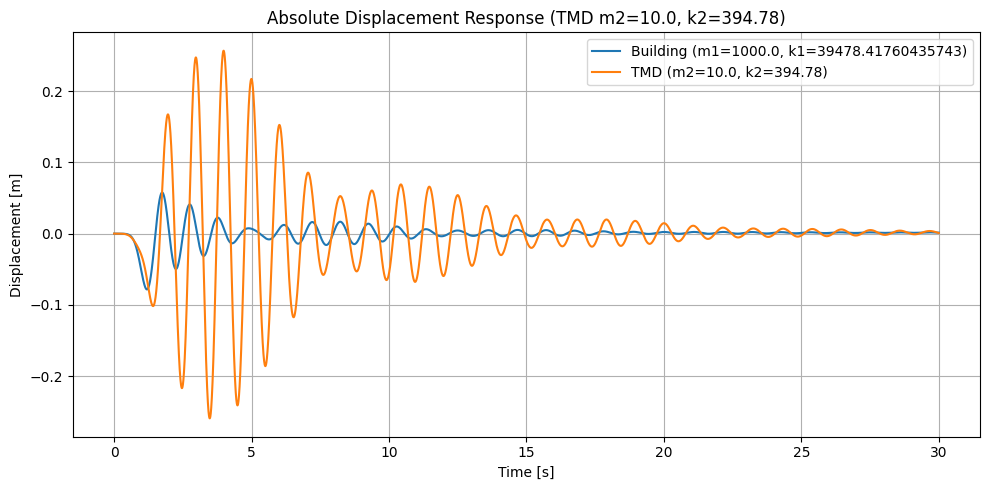

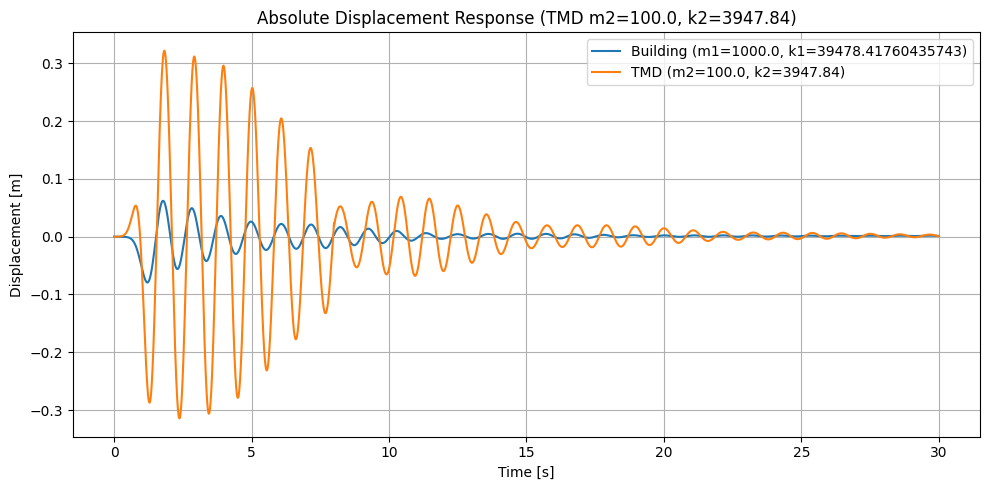

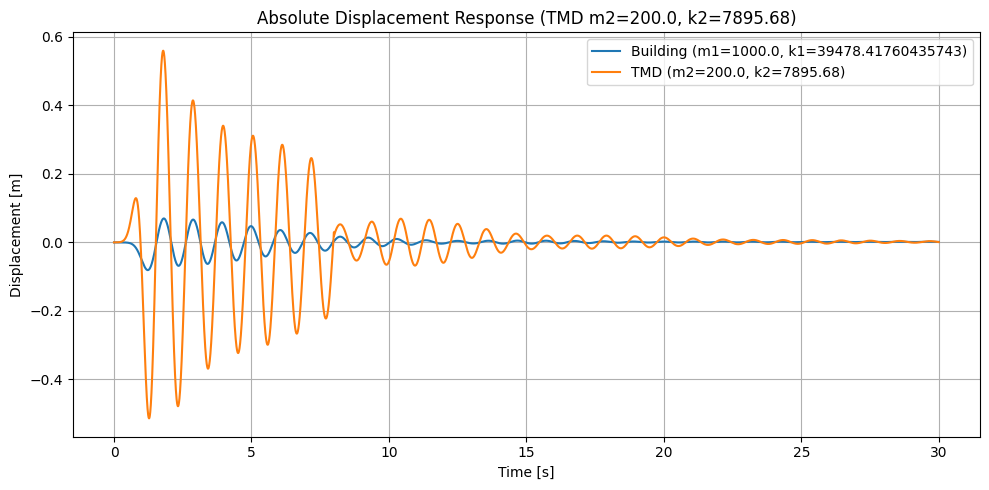

In [62]:
def simulate_displacement(tmd_masses, dt, T, ag, t_center, f0):
    """
    Simulates the displacement for different TMD masses, with the TMD tuned to the building's natural frequency.

    Args:
        tmd_masses (list): A list of TMD mass values.
        dt (float): Time step.
        T (float): Total simulation time.
        ag (numpy.ndarray): Ground acceleration.
        t_center (float): Center time for Ricker wavelet.
        f0 (float): Frequency of Ricker wavelet.

    Returns:
        list: A list containing the displacement simulation results for each TMD mass.
    """
    results = []
    t = np.arange(0, T + dt, dt)

    # Use the original building mass and stiffness
    m1_fixed = 1000.0
    k1_fixed = 39478.41760435743
    omega1_fixed = np.sqrt(k1_fixed / m1_fixed)
    c1_fixed = 2 * zeta1 * m1_fixed * omega1_fixed


    for m2 in tmd_masses:
        # Calculate k2 so that omega2 = omega1_fixed
        k2 = m2 * omega1_fixed**2
        omega2 = omega1_fixed # TMD frequency matches building frequency

        c2 = 2 * zeta2 * m2 * omega2 # Recalculate c2 based on the new omega2

        M = np.array([[m1_fixed, 0],
                      [0,  m2]])
        C = np.array([[c1_fixed + c2, -c2],
                      [-c2,      c2]])
        K = np.array([[k1_fixed + k2, -k2],
                      [-k2,      k2]])

        # Initial conditions for trapezoidal_rule
        r_0 = np.zeros(2)
        v_0 = np.zeros(2)

        # Initial acceleration from equilibrium: M r_ddot = -C r_dot - K r - M * 1 * ag
        M_init = np.array([[m1_fixed, 0],
                           [0,  m2]])
        C_init = np.array([[c1_fixed + c2, -c2],
                           [-c2,      c2]])
        K_init = np.array([[k1_fixed + k2, -k2],
                           [-k2,      k2]])

        r_ddot_init = np.zeros((len(t), 2))
        r_dot_init = np.zeros((len(t), 2))
        r_init = np.zeros((len(t), 2))

        F0_init = -M_init.dot(np.array([1, 1])) * ag[0]
        r_ddot_init[0] = np.linalg.solve(M_init, F0_init - C_init @ r_dot_init[0] - K_init @ r_init[0])


        # Call the trapezoidal_rule function
        r, r_dot, r_ddot = trapezoidal_rule(M, C, K, -M.dot(np.array([1, 1])) * ag[0], dt, r_0, v_0)

        # Absolute motion
        vg = np.cumsum(ag) * dt
        xg = np.cumsum(vg) * dt
        u = r + xg.reshape(-1, 1) * np.array([1, 1])
        results.append({'tmd_mass': m2, 'tmd_k': k2, 'time': t, 'displacement': u})

    return results

# Use the original building mass and stiffness in the global scope for plotting labels
m1_fixed = 1000.0
k1_fixed = 39478.41760435743

# Example usage (you can modify these lists)
tmd_masses_to_test = [10.0, 100.0, 200.0] # Example TMD masses
# tmd_k_values_to_test = [789.5683520871487, 1000.0] # No longer needed
simulation_results = simulate_displacement(tmd_masses_to_test, dt, T, ag, t_center, f0)

# You can then process and plot the results as needed
for result in simulation_results:
    plt.figure(figsize=(10, 5))
    plt.plot(result['time'], result['displacement'][:, 0], label=f"Building (m1={m1_fixed}, k1={k1_fixed})") # Using original m1 and k1 for building label
    plt.plot(result['time'], result['displacement'][:, 1], label=f"TMD (m2={result['tmd_mass']}, k2={result['tmd_k']:.2f})")
    plt.title(f'Absolute Displacement Response (TMD m2={result["tmd_mass"]}, k2={result["tmd_k"]:.2f})')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [63]:
import numpy as np

def calculate_rms(list1, list2):
    """
    Calculates the Root Mean Square (RMS) difference between two lists.

    Args:
        list1 (list or numpy.ndarray): The first list or array.
        list2 (list or numpy.ndarray): The second list or array.

    Returns:
        float: The RMS difference between the two lists. Returns NaN if the lists have different lengths.
    """
    if len(list1) != len(list2):
        print("Error: Lists must have the same length to calculate RMS.")
        return np.nan # Return NaN for Not a Number

    # Convert to numpy arrays for easier calculations
    arr1 = np.array(list1)
    arr2 = np.array(list2)

    # Calculate the squared difference
    squared_diff = (arr1 - arr2)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Calculate the square root of the mean squared difference (RMS)
    rms = np.sqrt(mean_squared_diff)

    return rms

# Example usage:
# list_a = [1, 2, 3, 4, 5]
# list_b = [1.1, 2.2, 3.1, 4.2, 5.1]
# rms_value = calculate_rms(list_a, list_b)
# print(f"The RMS difference is: {rms_value:.4f}")

# list_c = [1, 2, 3]
# list_d = [1, 2, 3, 4]
# rms_value_diff_length = calculate_rms(list_c, list_d)
# print(f"The RMS difference is: {rms_value_diff_length}")

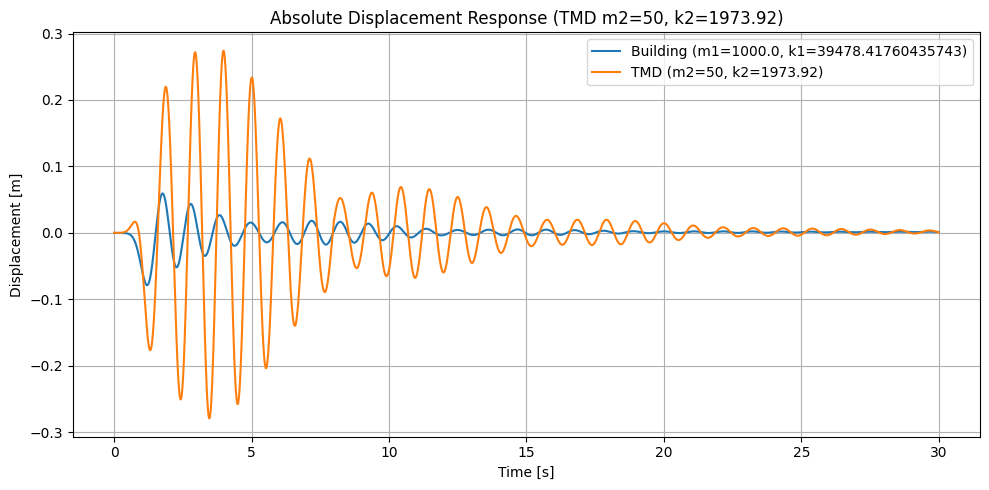

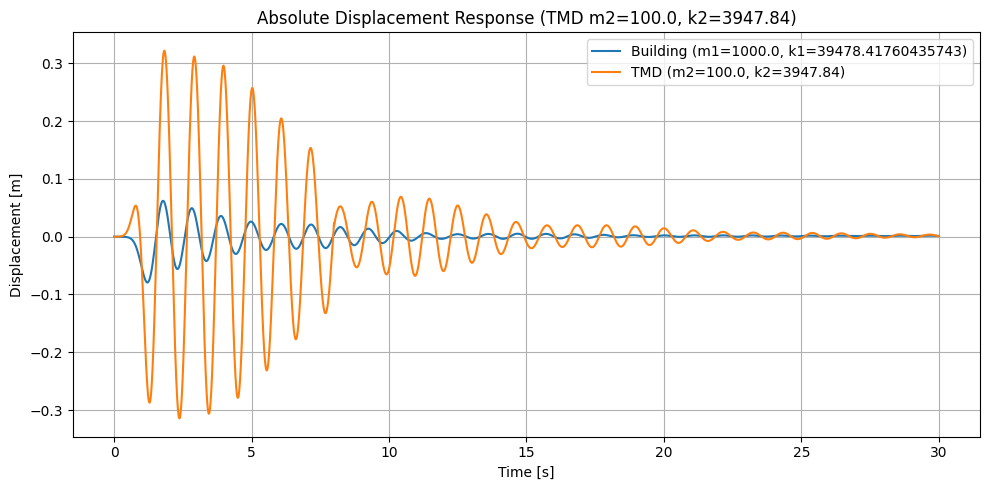

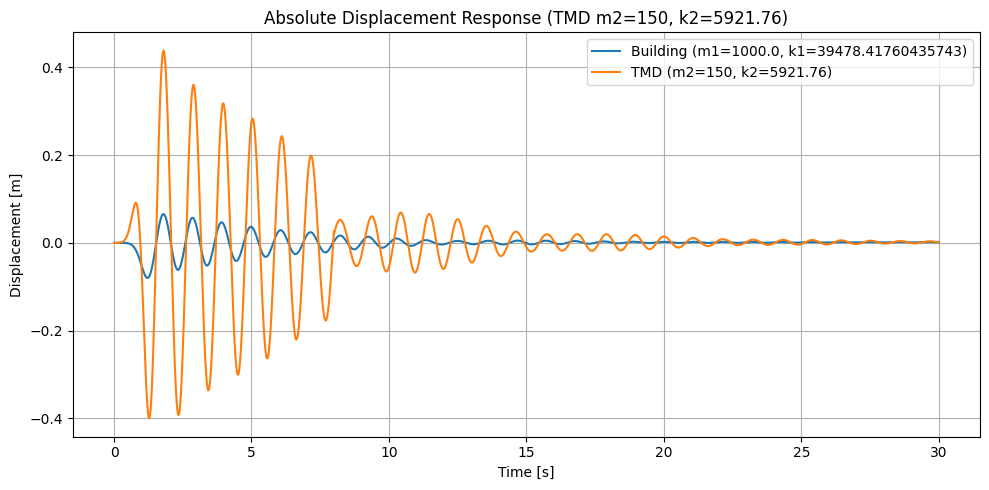

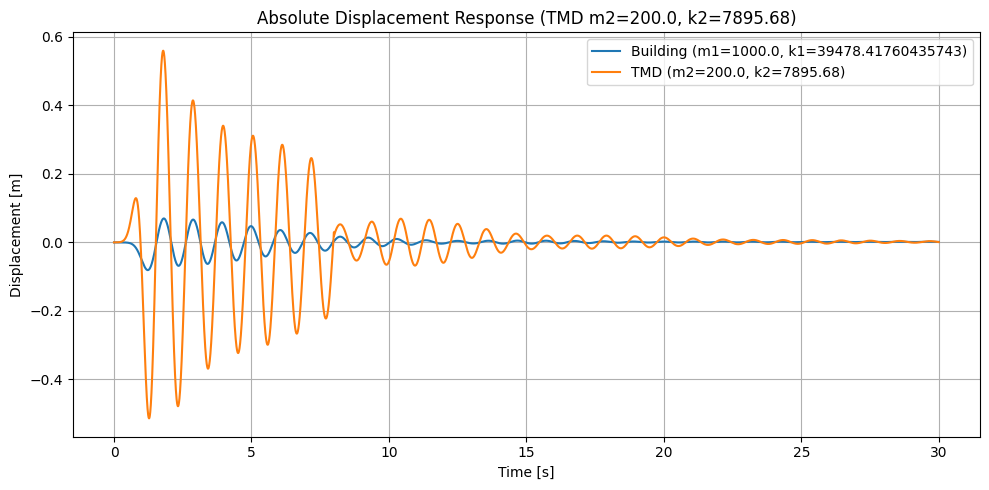

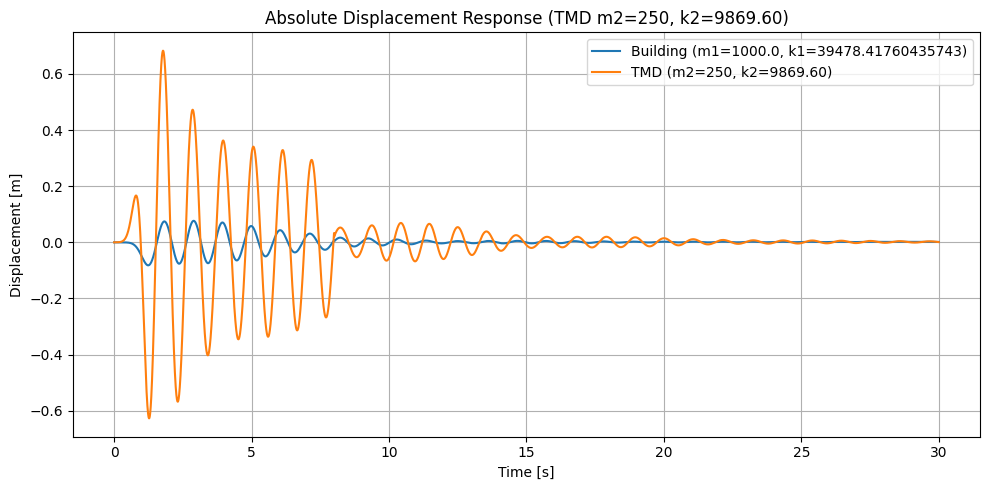

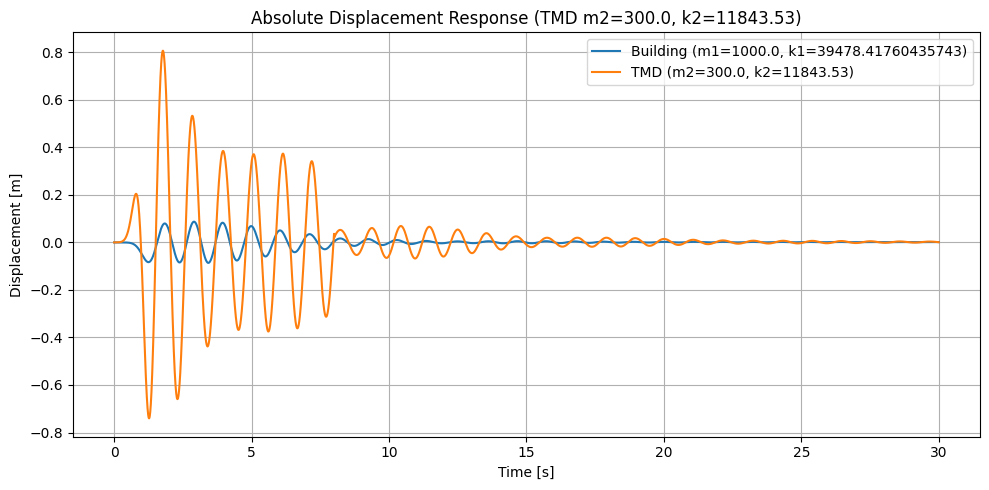

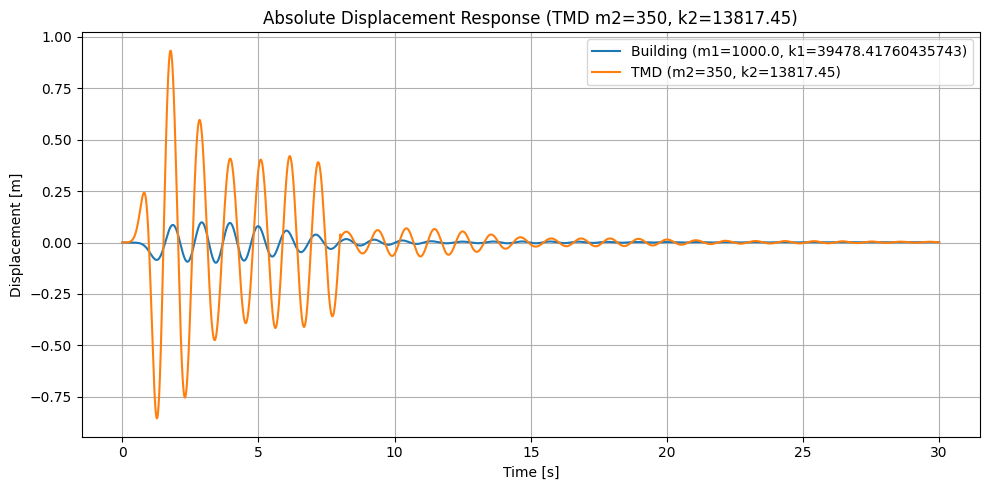

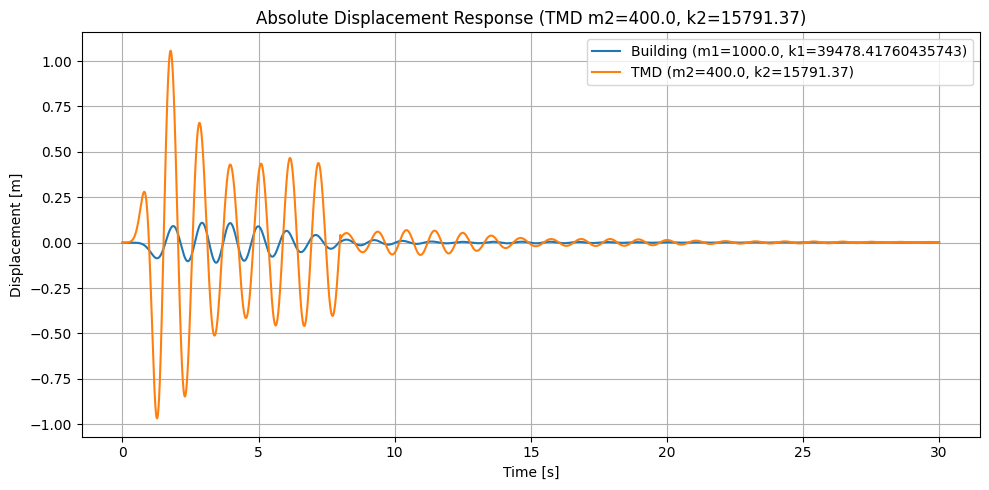

0.006126377121791157


In [64]:
m1_fixed = 1000.0
k1_fixed = 39478.41760435743

# Example usage (you can modify these lists)
tmd_masses_to_test = [50, 100.0, 150, 200.0, 250, 300.0, 350 , 400.0] # Example TMD masses
# tmd_k_values_to_test = [789.5683520871487, 1000.0] # No longer needed
simulation_results = simulate_displacement(tmd_masses_to_test, dt, T, ag, t_center, f0)

# You can then process and plot the results as needed
for result in simulation_results:
    plt.figure(figsize=(10, 5))
    plt.plot(result['time'], result['displacement'][:, 0], label=f"Building (m1={m1_fixed}, k1={k1_fixed})") # Using original m1 and k1 for building label
    plt.plot(result['time'], result['displacement'][:, 1], label=f"TMD (m2={result['tmd_mass']}, k2={result['tmd_k']:.2f})")
    plt.title(f'Absolute Displacement Response (TMD m2={result["tmd_mass"]}, k2={result["tmd_k"]:.2f})')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
print(calculate_rms(simulation_results[0]['displacement'][:, 0], simulation_results[2]['displacement'][:, 0]))

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Parameters (building only)
m1 = 1000.0     # Mass Building [kg]
f1 = 1.0        # Natural frequency of building [Hz]
zeta1 = 0.02    # Damping ratio of building


f0 = 1.0        # Frequency of Ricker//Earthquake [Hz]
A = 1.0         # Amplitude [m/s^2]
t_center = 1.0  # Peak Time[s]

dt = 0.002      # Time step [s]
T = 30.0        # Total simulation time [s]

omega1 = 2*np.pi*f1
k1     = m1 * omega1**2
c1     = 2 * zeta1 * m1 * omega1  # = 0 for undamped

# 2) Ground motion: Ricker wavelet
def ricker(t, f0):
    a = np.pi * f0 * t
    return (1 - 2*a*a) * np.exp(-a*a)

t  = np.arange(0, T + dt, dt)
ag = A * ricker(t - t_center, f0)           # ground acceleration [m/s^2]
vg = np.cumsum(ag) * dt                      # ground velocity
xg = np.cumsum(vg) * dt                      # ground displacement

# 3) State arrays (relative motion r=u-xg)
n = len(t)
r      = np.zeros(n)  # relative displacement
r_dot  = np.zeros(n)  # relative velocity
r_ddot = np.zeros(n)  # relative acceleration

# Initial acceleration from equilibrium: m r̈ = -c ṙ - k r - m*ag
r_ddot[0] = ( -c1*r_dot[0] - k1*r[0] - m1*ag[0] ) / m1

Keff = m1 + 0.5*dt*c1 + 0.25*dt*dt*k1  # scalar

for k in range(n-1):
    F_next = -m1 * ag[k+1]
    rhs = ( F_next
            - c1*( r_dot[k] + 0.5*dt*r_ddot[k] )
            - k1*( r[k] + 0.5*dt*r_dot[k] + 0.25*dt*dt*r_ddot[k] ) )
    r_ddot[k+1] = rhs / Keff
    r_dot[k+1]  = r_dot[k] + 0.5*dt*(r_ddot[k] + r_ddot[k+1])
    r[k+1]      = r[k]     + dt*r_dot[k] + 0.25*dt*dt*(r_ddot[k] + r_ddot[k+1])

# 5) Absolute response (u = r + xg)
u      = r + xg



In [66]:

for result in simulation_results:
  print(calculate_rms(u, result['displacement'][:, 0]))

0.016764683999804818
0.01776704741567226
0.01921061077757251
0.021004604431962656
0.023067412003913042
0.025333452865579104
0.027752989387559143
0.030289259715592688


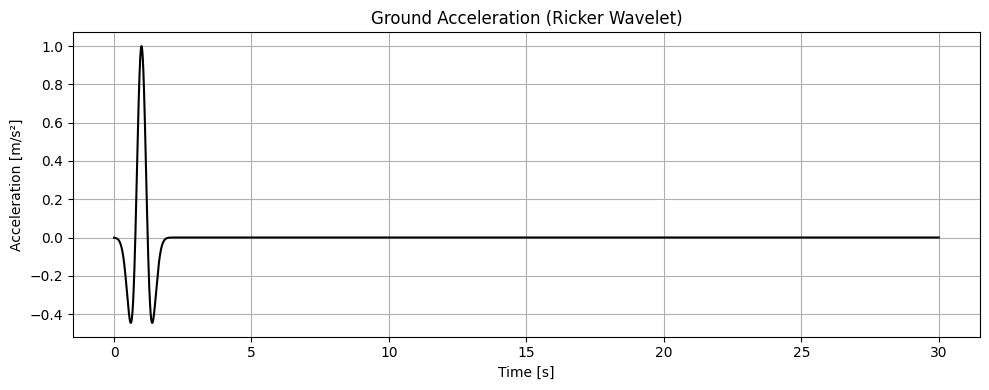

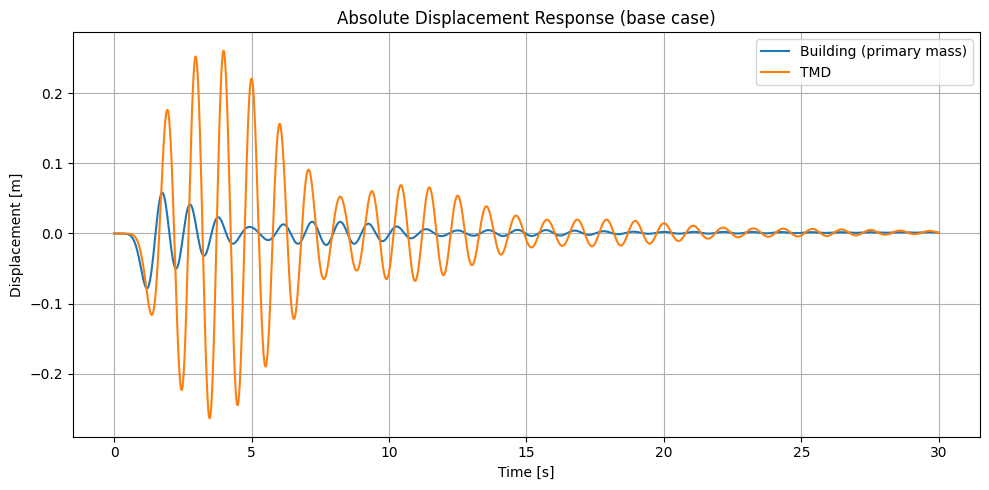

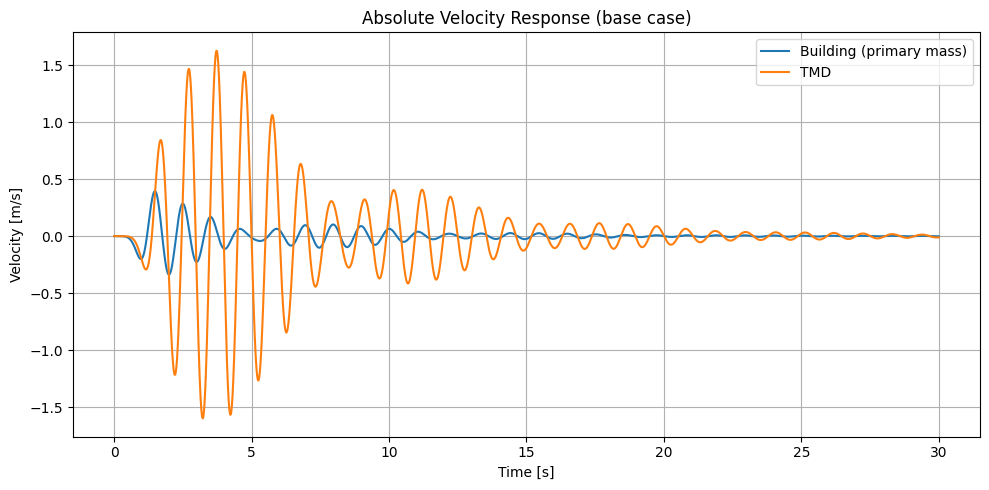

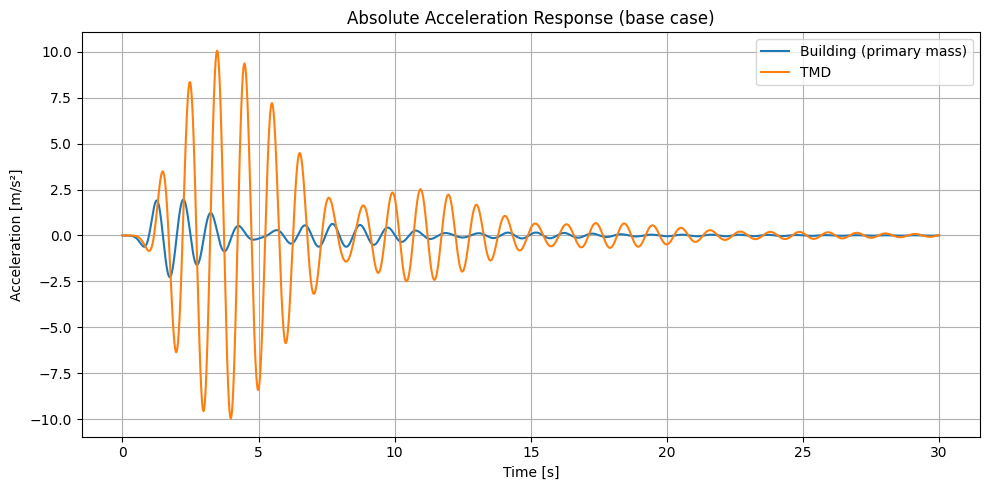

Peak Displacement (Building): 0.0784 m
Peak Displacement (TMD):      0.2640 m
Peak Velocity (Building):     0.3942 m/s
Peak Velocity (TMD):          1.6274 m/s
Peak Accel (Building):        2.2686 m/s²
Peak Accel (TMD):             10.0607 m/s²


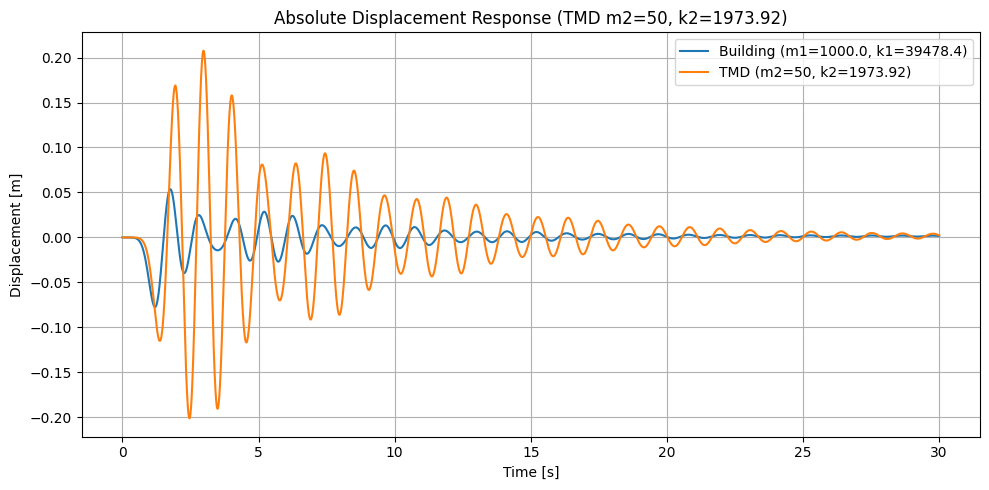

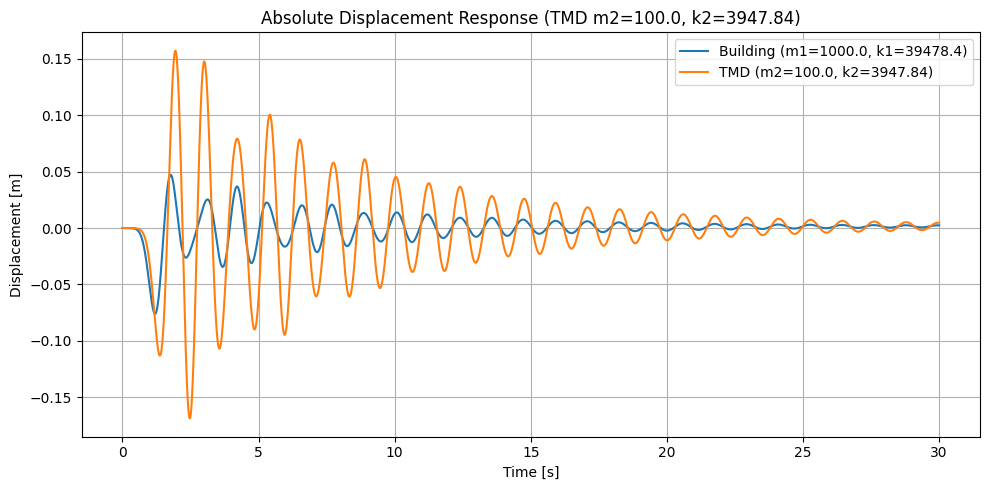

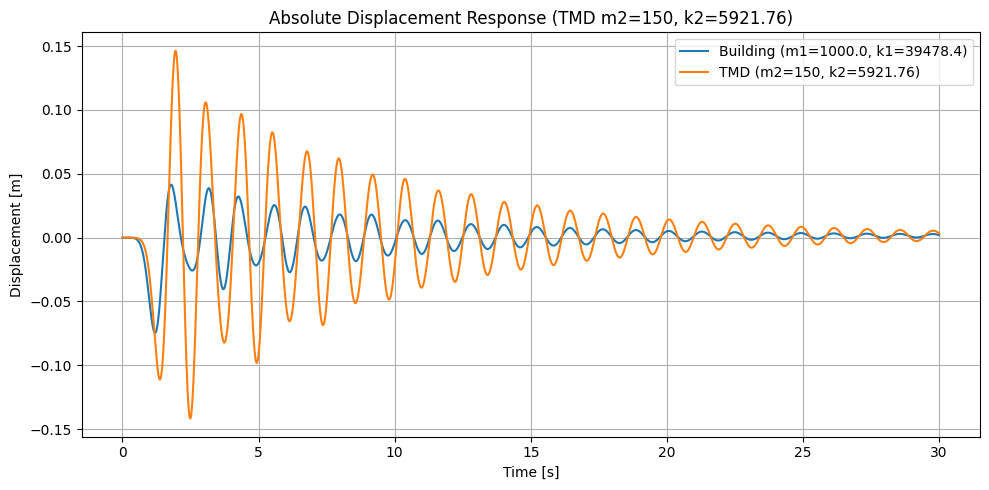

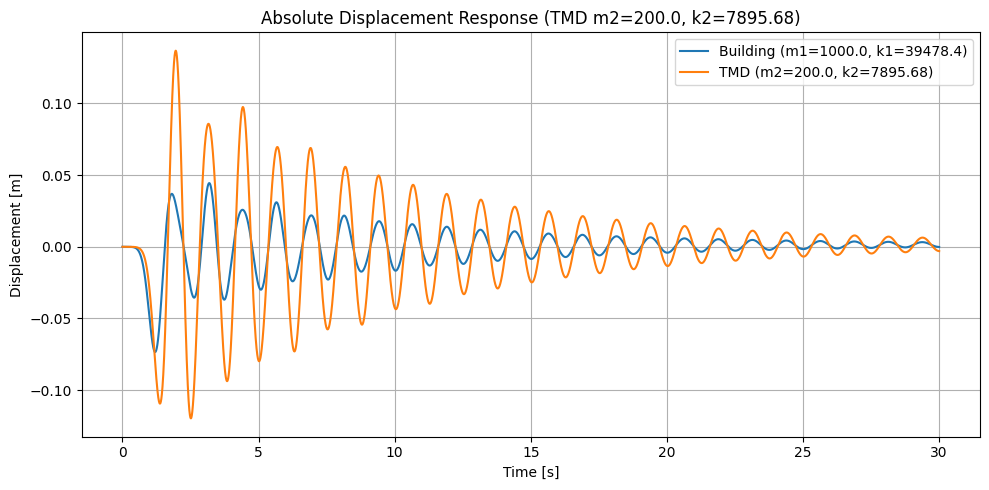

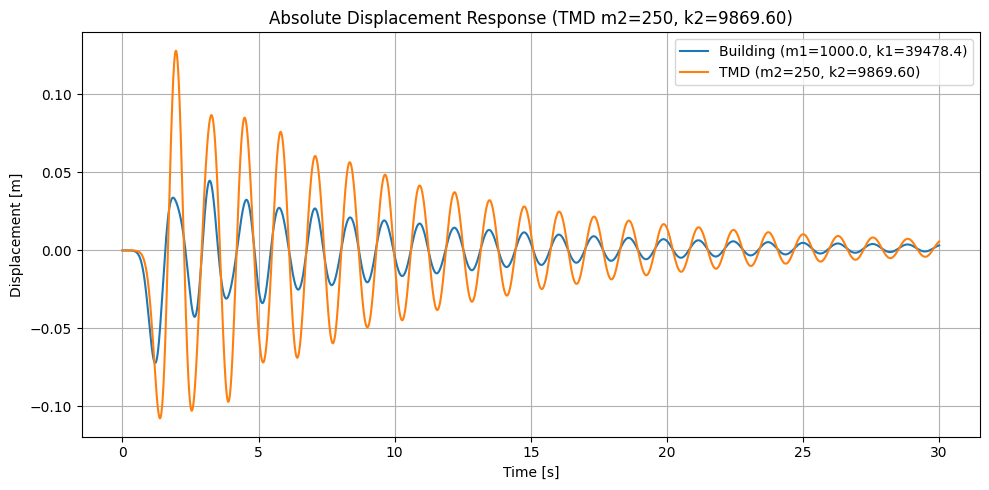

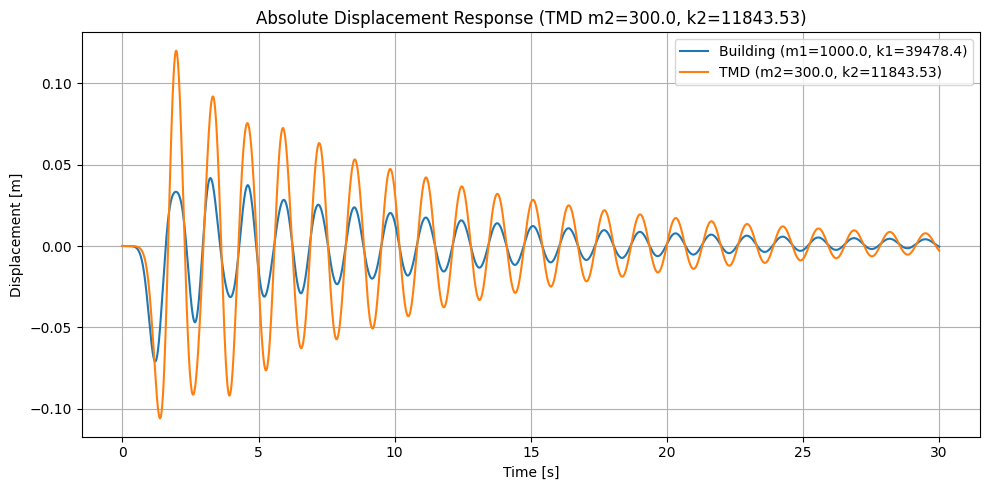

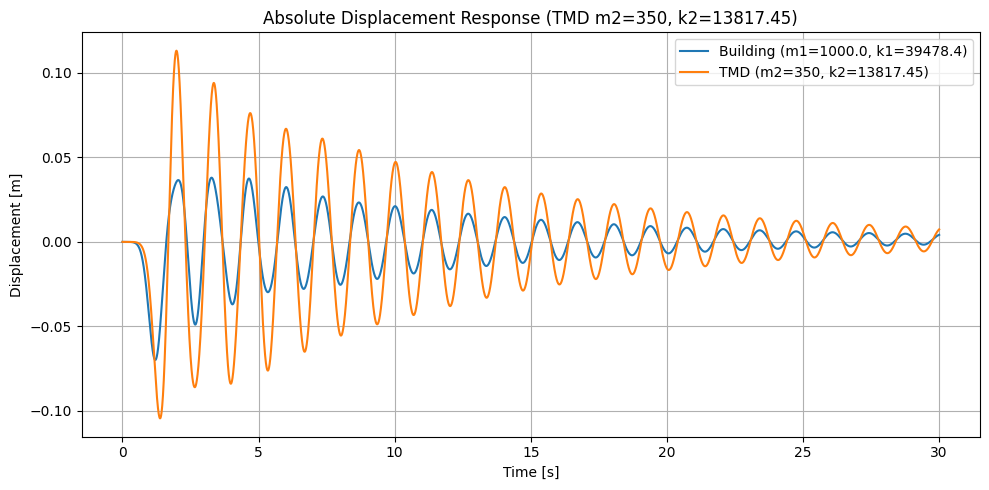

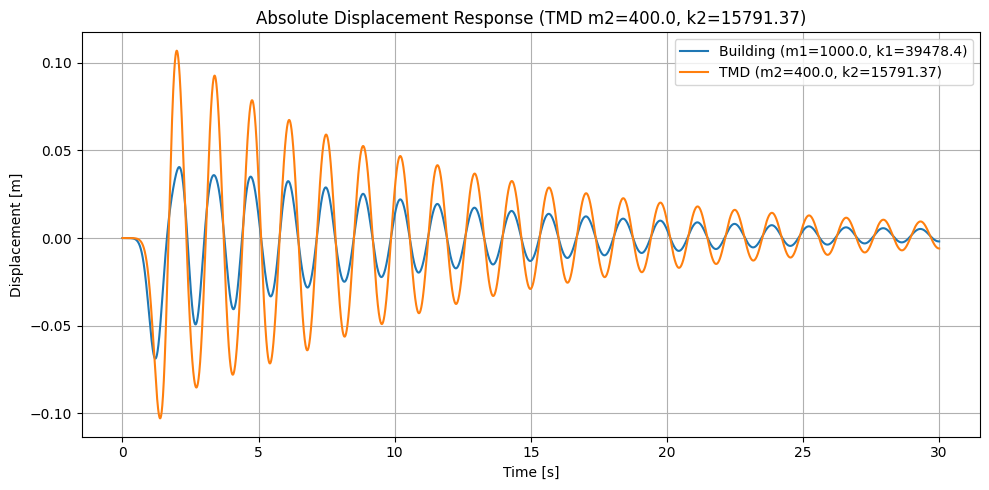

RMS difference between building responses (case 1 vs 3): 0.013748


In [67]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Variables
# -------------------------------
m1 = 1000.0     # Mass Building [kg]
f1 = 1.0        # Natural frequency of building [Hz]
zeta1 = 0.02    # Damping ratio of building
TMD_ratio = 0.02  # Ratio of TMD mass to building mass

m2 = m1 * TMD_ratio  # Mass TMD [kg]
f2 = 1.0             # Natural frequency of TMD (tuned to f1)
zeta2 = 0.05         # Damping ratio of TMD

f0 = 1.0        # Frequency of Ricker//Earthquake [Hz]
A = 1.0         # Amplitude [m/s^2]
t_center = 1.0  # Peak Time[s]

dt = 0.002      # Time step [s]
T = 30.0        # Total simulation time [s]

# -------------------------------
# Derived (building base case)
# -------------------------------
omega1 = 2 * np.pi * f1
omega2 = 2 * np.pi * f2

k1 = m1 * omega1**2
k2 = m2 * omega2**2
c1 = 2 * zeta1 * m1 * omega1
c2 = 2 * zeta2 * m2 * omega2

# -------------------------------
# Ground motion (Ricker wavelet)
# -------------------------------
def ricker(t, f0):
    a = np.pi * f0 * t
    return (1 - 2 * a**2) * np.exp(-a**2)

t = np.arange(0, T + dt, dt)
ag = A * ricker(t - t_center, f0)  # Ground acceleration [m/s^2]

# Precompute ground displacement/velocity once
vg = np.cumsum(ag) * dt
xg = np.cumsum(vg) * dt

# -------------------------------
# Newmark average-acceleration (trapezoidal) for 2-DOF
# -------------------------------
def trapezoidal_rule(M, C, K, ag, dt, T):
    """
    Integrates relative motion r for a 2-DOF base-excited system:
      M r̈ + C ṙ + K r = -M * 1 * ag
    using the Newmark average-acceleration (trapezoidal) method.

    Args:
        M, C, K: (2x2) numpy arrays
        ag: (n,) ground acceleration array
        dt: time step
        T: total time

    Returns:
        t, r, r_dot, r_ddot  (all relative to ground)
    """
    t = np.arange(0, T + dt, dt)
    n = len(t)

    r = np.zeros((n, 2))
    r_dot = np.zeros((n, 2))
    r_ddot = np.zeros((n, 2))

    # Effective matrix is constant for constant dt
    K_eff = M + 0.5 * dt * C + 0.25 * dt**2 * K
    K_eff_inv = np.linalg.inv(K_eff)

    # Base inertia vector (multiply by ag[k] each step)
    Gamma = -M.dot(np.array([1.0, 1.0]))

    # Initial acceleration: M r̈0 = Γ ag0 - C ṙ0 - K r0
    r_ddot[0] = np.linalg.solve(M, Gamma * ag[0] - C @ r_dot[0] - K @ r[0])

    for k in range(n - 1):
        F_next = Gamma * ag[k + 1]
        rhs = (F_next
               - C.dot(r_dot[k] + 0.5 * dt * r_ddot[k])
               - K.dot(r[k] + 0.5 * dt * r_dot[k] + 0.25 * dt**2 * r_ddot[k]))
        r_ddot[k + 1] = K_eff_inv.dot(rhs)
        r_dot[k + 1]  = r_dot[k] + 0.5 * dt * (r_ddot[k] + r_ddot[k + 1])
        r[k + 1]      = r[k]     + dt * r_dot[k] + 0.25 * dt**2 * (r_ddot[k] + r_ddot[k + 1])

    return t, r, r_dot, r_ddot

# -------------------------------
# Sweep helper: vary TMD mass
# -------------------------------
def simulate_displacement(tmd_masses, dt, T, ag, zeta1, zeta2,
                          m1_fixed=1000.0, k1_fixed=39478.41760435743):
    """
    Simulates absolute displacement for various TMD masses tuned to the building.

    Returns list of dicts with time, displacement (absolute), and metadata.
    """
    results = []

    omega1_fixed = np.sqrt(k1_fixed / m1_fixed)
    c1_fixed = 2 * zeta1 * m1_fixed * omega1_fixed

    # ground kinematics (once)
    t = np.arange(0, T + dt, dt)
    vg = np.cumsum(ag) * dt
    xg = np.cumsum(vg) * dt

    for m2 in tmd_masses:
        # tune TMD to building
        omega2 = omega1_fixed
        k2 = m2 * omega2**2
        c2 = 2 * zeta2 * m2 * omega2

        M = np.array([[m1_fixed, 0.0],
                      [0.0,      m2   ]])
        C = np.array([[c1_fixed + c2, -c2],
                      [-c2,            c2]])
        K = np.array([[k1_fixed + k2, -k2],
                      [-k2,            k2]])

        # integrate relative motion
        _, r, r_dot, r_ddot = trapezoidal_rule(M, C, K, ag, dt, T)

        # absolute motions
        ones = np.array([1.0, 1.0])
        u      = r      + xg.reshape(-1, 1) * ones
        u_dot  = r_dot  + vg.reshape(-1, 1) * ones
        u_ddot = r_ddot + ag.reshape(-1, 1) * ones

        results.append({
            'tmd_mass': m2,
            'tmd_k': k2,
            'time': t,
            'displacement': u,     # absolute
            'relative': r,
            'vel_abs': u_dot,
            'acc_abs': u_ddot,
        })

    return results

# -------------------------------
# Base 2-DOF run (single case) using the same machinery
# -------------------------------
M = np.array([[m1, 0.0],
              [0.0, m2  ]])
C = np.array([[c1 + c2, -c2],
              [-c2,      c2]])
K = np.array([[k1 + k2, -k2],
              [-k2,      k2]])

_, r, r_dot, r_ddot = trapezoidal_rule(M, C, K, ag, dt, T)
u      = r      + xg.reshape(-1, 1) * np.array([1.0, 1.0])
u_dot  = r_dot  + vg.reshape(-1, 1) * np.array([1.0, 1.0])
u_ddot = r_ddot + ag.reshape(-1, 1) * np.array([1.0, 1.0])

# -------------------------------
# Plots for this base case
# -------------------------------
plt.figure(figsize=(10, 4))
plt.plot(t, ag, color='black')
plt.title('Ground Acceleration (Ricker Wavelet)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u[:, 0], label='Building (primary mass)')
plt.plot(t, u[:, 1], label='TMD')
plt.title('Absolute Displacement Response (base case)')
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_dot[:, 0], label='Building (primary mass)')
plt.plot(t, u_dot[:, 1], label='TMD')
plt.title('Absolute Velocity Response (base case)')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t, u_ddot[:, 0], label='Building (primary mass)')
plt.plot(t, u_ddot[:, 1], label='TMD')
plt.title('Absolute Acceleration Response (base case)')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration [m/s²]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Peak Displacement (Building): {np.max(np.abs(u[:,0])):.4f} m")
print(f"Peak Displacement (TMD):      {np.max(np.abs(u[:,1])):.4f} m")
print(f"Peak Velocity (Building):     {np.max(np.abs(u_dot[:,0])):.4f} m/s")
print(f"Peak Velocity (TMD):          {np.max(np.abs(u_dot[:,1])):.4f} m/s")
print(f"Peak Accel (Building):        {np.max(np.abs(u_ddot[:,0])):.4f} m/s²")
print(f"Peak Accel (TMD):             {np.max(np.abs(u_ddot[:,1])):.4f} m/s²")

# -------------------------------
# RMS helper
# -------------------------------
def calculate_rms(list1, list2):
    """
    Root Mean Square (RMS) difference between two sequences of equal length.
    """
    if len(list1) != len(list2):
        print("Error: Lists must have the same length to calculate RMS.")
        return np.nan
    arr1 = np.asarray(list1)
    arr2 = np.asarray(list2)
    return np.sqrt(np.mean((arr1 - arr2)**2))

# -------------------------------
# Sweep example across TMD masses
# -------------------------------
m1_fixed = 1000.0
k1_fixed = 39478.41760435743  # ~ (2*pi*1 Hz)^2 * 1000

tmd_masses_to_test = [50, 100.0, 150, 200.0, 250, 300.0, 350, 400.0]
simulation_results = simulate_displacement(
    tmd_masses_to_test, dt, T, ag, zeta1=zeta1, zeta2=zeta2,
    m1_fixed=m1_fixed, k1_fixed=k1_fixed
)

for result in simulation_results:
    plt.figure(figsize=(10, 5))
    plt.plot(result['time'], result['displacement'][:, 0],
             label=f"Building (m1={m1_fixed}, k1={k1_fixed:.1f})")
    plt.plot(result['time'], result['displacement'][:, 1],
             label=f"TMD (m2={result['tmd_mass']}, k2={result['tmd_k']:.2f})")
    plt.title(f'Absolute Displacement Response (TMD m2={result["tmd_mass"]}, k2={result["tmd_k"]:.2f})')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example RMS between the first and third building responses in the sweep
if len(simulation_results) >= 3:
    rms_val = calculate_rms(simulation_results[0]['displacement'][:, 0],
                            simulation_results[2]['displacement'][:, 0])
    print(f"RMS difference between building responses (case 1 vs 3): {rms_val:.6f}")


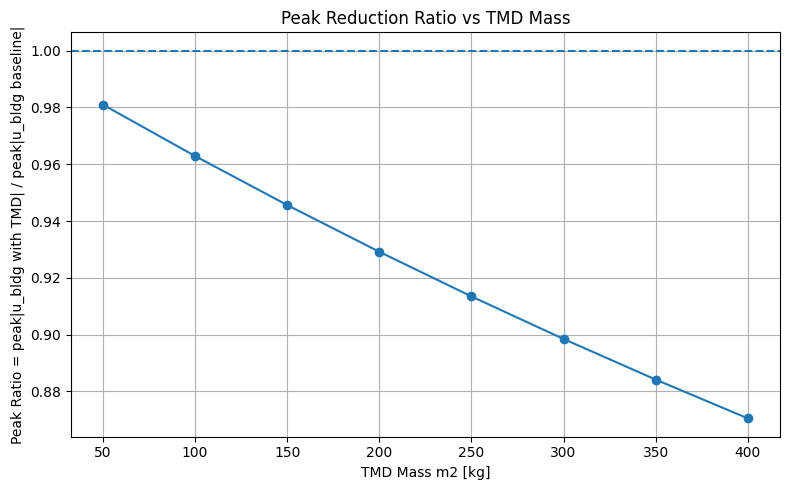

In [69]:
# ---------- Baseline (no TMD) SDOF using the same Newmark/trapezoidal idea ----------
def sdof_trapezoidal(m, k, zeta, ag, dt, T):
    """
    Absolute response u(t) of a single-DOF base-excited oscillator:
        m r¨ + c ṙ + k r = -m ag
    with u = r + xg, where xg is the ground displacement from ag.
    """
    t = np.arange(0, T + dt, dt)
    n = len(t)

    # damping
    omega = np.sqrt(k / m)
    c = 2.0 * zeta * m * omega

    # ground kinematics
    vg = np.cumsum(ag) * dt
    xg = np.cumsum(vg) * dt

    # alloc (relative)
    r      = np.zeros(n)
    r_dot  = np.zeros(n)
    r_ddot = np.zeros(n)

    # effective scalar
    Keff = m + 0.5 * dt * c + 0.25 * dt**2 * k

    # initial accel
    r_ddot[0] = (-c * r_dot[0] - k * r[0] - m * ag[0]) / m

    # step
    for i in range(n - 1):
        F_next = -m * ag[i + 1]
        rhs = (F_next
               - c * (r_dot[i] + 0.5 * dt * r_ddot[i])
               - k * (r[i] + 0.5 * dt * r_dot[i] + 0.25 * dt**2 * r_ddot[i]))
        r_ddot[i + 1] = rhs / Keff
        r_dot[i + 1]  = r_dot[i] + 0.5 * dt * (r_ddot[i] + r_ddot[i + 1])
        r[i + 1]      = r[i]     + dt * r_dot[i] + 0.25 * dt**2 * (r_ddot[i] + r_ddot[i + 1])

    # absolute
    u = r + xg
    u_dot = r_dot + vg
    u_ddot = r_ddot + ag
    return t, u, u_dot, u_ddot

# ---------- Compute baseline (no TMD) peak and reduction ratios ----------
# Uses your building parameters m1_fixed, k1_fixed, zeta1 and excitation ag, dt, T
t_baseline, u_baseline, _, _ = sdof_trapezoidal(m1_fixed, k1_fixed, zeta1, ag, dt, T)
peak_baseline = np.max(np.abs(u_baseline))

# For each TMD case, take the building's absolute displacement (column 0)
mass_list = []
peak_ratio_list = []   # = peak_with_TMD / peak_baseline  (values < 1 mean reduction)

for res in simulation_results:
    u_building = res['displacement'][:, 0]
    peak_with_tmd = np.max(np.abs(u_building))
    ratio = peak_with_tmd / peak_baseline

    mass_list.append(res['tmd_mass'])
    peak_ratio_list.append(ratio)

# ---------- Plot: Peak Reduction Ratio vs TMD Mass ----------
plt.figure(figsize=(8, 5))
plt.plot(mass_list, peak_ratio_list, marker='o')
plt.axhline(1.0, linestyle='--')  # baseline reference
plt.title('Peak Reduction Ratio vs TMD Mass')
plt.xlabel('TMD Mass m2 [kg]')
plt.ylabel('Peak Ratio = peak|u_bldg with TMD| / peak|u_bldg baseline|')
plt.grid(True)
plt.tight_layout()
plt.show()

